In [1]:
"""
Moving averages ucinaja mi zyski... One maja sens tylko pozornie. Jak patrze na wykres widze ze zwykle 
wtedy byly wzrosty. Ale jak wezmiesz pod uwage:
- wejscie na koncu dnia (czesto wzrost juz byl duzy w tym momencie)
- wyjscie po tym gdy srednia opada (dopiero x dni pozniej)
Dlatego zreszta ludzie wymyslali 2 srednie (krotkie i dlugie)

Jezeli chodzi o wykrycie trendu srednia nie jest duzo lepsza od Janusza patrzacego na wykres...

Musze podejsc do tego bardziej usystematyzowanie... A nie probowac jakies zasady z dupy

- Zakladajac cene X i koszt transakcji Y, jaki wzrost ceny jest potrzebny do zarobienia czegokolwiek?

- Jak czesto w zalozonym okresie cena wzrosla w poprzednich lb dniach o wymagany % ?
    - Czy sa okresy gdy czestotliwosc jest wieksza?
        -> W teori przy trendzie wzrostowym tak powinno byc
    - Jak wyglada funcka f(lb) -> break_even
    - Czy widac podobienstwa na innych symbolach?
- Jakie bylby expected return dla zalozonego okresu?
    expected_return = p(win)*avg(win) + p(loss)*avg(loss)

Pomysl-1:
- Zakladajac istnie wydluzonych okresow w ktorych cena rosnie (upward trend)
- W takim okresie przewidywany wzrost ceny bedzie pozytywny, tj. srednio bez specjalnych 
    zdolnosci jezeli zainwestujesz przez X dni to zyskasz
- Jezeli jestem w stanie mniej wiecej okreslic czy dana spolka jest w takim okresie moge w nia inwestowac na X dni
- Problematyczne kwestie:
    -> Jak zdefiniowac taki okres na podstawie danych historycznych?
    -> Ile jeszcze dana spoka pozostanie w takim stanie?
    -> Czy to nie jest tak trudne zadanie jak przewidzenie ruchu ceny? Czy nie zamieniam jedego niemozliwego
        problemu na drugi?
- [?] Jak szybko w danym okresie (po ile transakcjach) returns zebiegaja sie z oczekiwanymi?
    Okres powinien trwac na tyle dlugo ze po jego wykryciu jestem w stanie zrobic tyle transakcjii.
    W zaleznosci od ilosc transakcji bede wtedy tez w stanie okreslic czy gra jest warta swieczki...
    



Asymetrical approach (https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2903855):
- This artical confirms that simple Moving Average approach is often used to identified up/down trends
- There is information assymetry in up/down trends. Up trends tends to have less abrupt begining. Down trends
tend to start more rapidly (short price fall at the end of up-trend / beg of down-trendd)
- The results show that a more responsive way (i.e. using a shorter MA length) to locate the ending time points of uptrends always
helps to achieve a better average return.
- Described startegy is long/short. It would need modification for long-only
- In general, use one pair (long and short SMA) to identify LONG ENTRY, and the other pair (shorter) to define LONG EXIT




""";

In [2]:
"""
Co pomogloby mi w decyzji oprocz ceny?

- Competitors and|or index performance 
- Volume and price (bull vs. bear on given day)
- Rate of changes
- Recent maxima | minima and time passed since then


behaviours:
- Following the crowd (even if it make not make sense)
- Fear for loss is bigger than possibile profit
- Gambler’s fallacy
- contrarian forex trader would typically take a long position in a currency pair 
when there is an overwhelming degree of pessimism that has pushed the price of the asset 
down to an extreme level that is below what it is intrinsically worth.

""";

In [3]:
"""
Processing flow:
- Prepare data
- Get random periods from data (with all necessery columns)
- Calculate competitors metrics
- Calcualte sentiment metrics
- Show all resuls
""";

In [4]:
"""
Volume is counted as the total number of shares that are actually traded (bought and sold) during the 
trading day or specified set period of time.


100 transakcji
cena spadla o 5 zl
co to znaczy?


Sentiment, usually -> is market/stock/etc. 
    bullish (more people think it will go up)
    bearish (more people think it will go down)

In theory, if more and more people will think it will go up, they will hold their positions. Also more people
would like to buy it (driving price up)

no pos/neg days weighted by volume? volotality could also be helpful...

Anyway, don't fall into the trap of "perfect" indicator that with high certanity predicts... Smartest people and
funds can't do it.

What you are looking at is to trade the way that without certenity or "holy grail" you can have higher profits
that passive buy&hold. 



How to test (statistiically) if used approach (hypothesis) has any sense?
- Draw random symbol/period - test performance over many traials
- Compare the above with benchmark performance. Performance achieved with method on randomly generated data. 


TODOs:
OK - Clean script (names, cells, etc.). It should be easy to restart kernel without worry
OK - Create POC function that will allow to:
    -> run single cell
    -> see data and make unbiased human decision for the investment
    -> write assumptions and observation
    -> compare it with 2nd period. Was I right? what could be done better
- Come up with good set of rules that can be codified
- Codify assumptions and create function to test approach on many trials
"""
;

''

In [23]:
########################
### AFTER CLEAN UP
########################

In [500]:
# built in
import random
import sys
sys.path.insert(0, '/Users/slaw/osobiste/trading')

import time
import math

# import logging
# logger = logging.getLogger()
# logger.setLevel(logging.DEBUG)
# logging.debug("test")

# 3rd party
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

from mpl_finance import candlestick_ohlc
import matplotlib.dates as mpl_dates

import numpy as np
import pandas as pd

# custom
from lse_data import LSEData
# from backtester import Backtester
# from signal_generator import SignalGenerator
# from strategies import helpers
# from ftse_symbols import ftse_100
import ftse_symbols

# import position_size
# import results
# import helpers
import rules

In [25]:
%matplotlib notebook
register_matplotlib_converters()

In [26]:
def get_base_data(print_sample=True):
    """
    Gets FTSE100 data from disk and loads it as {symbol: df}
    """
    lse_data = LSEData(pricing_data_path='/Users/slaw/osobiste/trading/pricing_data')
    universe = lse_data.load(
        symbols=lse_data.indicies_stocks['FTSE100']
    )
    if print_sample:
        print(f'No. of stocks in universe: {len(universe.keys())}')
        print('Sample data:')
        print(universe['AAL'].tail(10))
    return universe

In [27]:
def needed_price_rise(entry_price=None, trx_cost=6, trx_type='long', profit=0):
    """
    Returns how much price need to rise (long) in order to achieve given profit
    """
    fees = 2*trx_cost
    if trx_type == 'long':
        exit_price = profit + fees + entry_price
        perc_increase = (exit_price-entry_price)/entry_price
        return perc_increase

print(needed_price_rise(entry_price=100, profit=0))

0.12


In [28]:
def winrate_expected_return(arr, lb, profit=0):
    """
    Given array of prices, lookback period and desired profit - calculate winrate and expected returns.
    
    Metrics are based on assumption that one makes trade every day, holds it for lookback period. It can be
    interpreted as winrate/expected return of random trade (that lasted "lb" days) over given period (arr).
    """
    cnt_all = 0
    cnt_pos = 0
    sum_win = 0
    sum_loss = 0
    for idx, exit in enumerate(arr):
        if idx < lb-1:
            continue
        entry = arr[idx-(lb-1)]
        diff = (exit - entry)
        perc_diff = diff/entry

        req_change = needed_price_rise(
            entry_price=entry,
            profit=profit # 0 = break even
        )

        if perc_diff >= req_change:
            cnt_pos += 1
            sum_win += diff
        else:
            sum_loss += abs(diff)

        cnt_all += 1

    perc_win = round((cnt_pos/cnt_all)*100,0)
    
    if cnt_pos == 0:
        expexted_ret = -sum_loss/(cnt_all-cnt_pos)
    elif sum_loss == 0:
        expexted_ret = sum_win/cnt_pos
    else:
        expexted_ret = (perc_win/100)*(sum_win/cnt_pos) - ((100-perc_win)/100)*(sum_loss/(cnt_all-cnt_pos))
    expexted_ret = round(expexted_ret, 1)
    
    return perc_win, expexted_ret

In [29]:
def print_symbol_sectors_frequency():
    sectors= {}
    for el in ftse_symbols.ftse_100:
        sector = el['sector']
        if sector in sectors:
            sectors[sector] += 1
        else:
            sectors[sector] = 1
    for k, v in sorted(list(sectors.items()), key=lambda x: x[1], reverse=True):
        print(f'{k}: {v}')

print_symbol_sectors_frequency()

Support Services: 8
Insurance: 7
Media: 6
Financial Services: 5
Banks: 5
Household Goods & Home Construction: 5
Gas, Water & Multi-utilities: 5
Mining: 4
Metals & Mining: 4
Travel & Leisure: 4
Food & Drug Retailers: 4
General Industrials: 4
Pharmaceuticals & Biotechnology: 3
Software & Computer Services: 3
Real Estate Investment Trusts: 3
Retailers: 2
Aerospace & Defence: 2
Oil & Gas Producers: 2
Tobacco: 2
Telecommunications: 2
Personal Goods: 2
Beverages: 2
Chemicals: 2
General Retailers: 2
Food Producers: 1
Construction & Materials: 1
Travel and Leisure: 1
Electronic & Electrical Equipment: 1
Consumer services: 1
Investment Services: 1
Automobiles & Parts: 1
Forestry & Paper: 1
Equity Investment Instruments: 1
Health Care Equipment & Services: 1


In [30]:
def prepare_data(universe, ma=25, ma_label='close'):
    """
    Given raw data (e.g. output from `get_base_data`) run some computations (e.g. moving average) that can/will
    be used later on.
    Idea is to run things that requires whole time series. Things that would be harder to compute when one
    have just randomly selected chunk of time-series.
    """
    data = {}
    for symbol, org_df in universe.items():
        df = pd.DataFrame()
        df[f'ma{ma}'] = org_df[ma_label].rolling(ma).mean()
        prepared_symbol = pd.concat(
            [org_df, df],
            axis=1,
        )
        prepared_symbol = prepared_symbol[ma:]
        data[symbol] = prepared_symbol
    return data

In [31]:
def get_random_symbol_period(lb=None, lf=None, universe=None):
    """
    Given universe of data, randomly select symbol and cut two time serieis from it.
    First one will have lenght of lookback (`lb`) and the second one will start chronologically
    right after 1st one, but will last for lookforward (`lf`) days.
    
    Think about it as two consequitive time periods for random symbol and random date.  
    """
    sym = random.choice(list(universe.keys()))
    data = universe[sym]
    
    # dates to choose from
    dates = data.index.tolist()
    idx = random.randint(lb+1, len(dates)-(lf-1))
    
    # define periods
    first_period = data[idx-lb : idx]
    second_period = data[idx : idx+lf]
    
    return sym, first_period, second_period

In [32]:
def index_stocks_for_period(universe=None, period=None, label='close'):
    """
    Given `universe` and `label` calculate basic statistics for all symbols in the unvierse in given `period`.
    Metrics are:
        - list of daily returns
        - avg. daily return
        - total % change
        - volatility (as normalized standard deviation)
    
    """
    lst_period = period.index.tolist()
    start = lst_period[0]
    end = lst_period[-1]
    res = {}
    for sym, df in universe.items():
        data = df[start:end][label]
        if len(data) == 0:
            continue
        res[sym] = {}
        res[sym][label] = data.tolist()
        res[sym]['daily_ret'] = data.pct_change(1).tolist()[1:]
        res[sym]['avg_daily_ret'] = np.mean(res[sym]['daily_ret'])
        res[sym]['total_perc_change'] = (res[sym][label][-1] - res[sym][label][0]) / res[sym][label][0]
        res[sym]['volatility'] = np.std(res[sym][label]) / np.mean(res[sym][label])
        res[sym]['avg_daily_range'] = np.mean(df[start:end]['high'] - df[start:end]['low'])
    return res

In [165]:
def _sector_index_metrics(symbol, symbols_lst, index_stocks_data, label):
    """
    Helper func for compare_sector_index.
    ranks -> bigger is better
    len(data) -> contains all symbols (symbols_lst+symbol)
    """
    if len(symbols_lst) == 0:
        return {}
    data = []
    for s in (symbols_lst + [symbol]):
        if s not in index_stocks_data:
            continue
        data.append(
            (s, (
                index_stocks_data[s]['avg_daily_ret'],
                index_stocks_data[s]['total_perc_change'],
                index_stocks_data[s]['volatility'],
                index_stocks_data[s]['avg_daily_range'],
                )
            )
        )
        
    ordered_ret = sorted([(s, m[0]) for s, m in data], key = lambda x: x[1])
    ordered_total_change = sorted([(s, m[1]) for s, m in data], key = lambda x: x[1])
    ordered_vol = sorted([(s, m[2]) for s, m in data], key = lambda x: x[1])
    return {
        f'{label}_cnt': len(data),
        f'{label}_return_rank': [s for s, _ in ordered_ret].index(symbol) + 1,
        f'{label}_volatility_rank': [s for s, _ in ordered_vol].index(symbol) + 1,
        f'{label}_total_change_rank': [s for s, _ in ordered_total_change].index(symbol) + 1,
        f'{label}_avg_daily_ret': float(np.mean([m[0] for s, m in data if s != symbol]))
    }


def compare_sector_index(index_symbols=None, symbol=None, index_stocks_data=None):
    """
    For given symbol calculate index and sector metrics. It is done be comparing
    symbol data with statistics from `index_symbols` (index_stocks_for_period function output)
    """
    symbol_sector = [el['sector'] for el in index_symbols if el['symbol']==symbol][0]
    symbol_competitors = {
        'sector': [],
        'index': [],
    }
    # Get sectors frequency and competitors
    sector_competitor_cnt = 0
    for el in index_symbols:
        if el['symbol'] == symbol:
            continue
        sector = el['sector']
        if sector == symbol_sector:
            sector_competitor_cnt += 1
            symbol_competitors['sector'].append(el['symbol'])
        if el['symbol'] in index_stocks_data:
            symbol_competitors['index'].append(el['symbol'])
    # Index metrics
    index_metrics = _sector_index_metrics(
        symbol, symbol_competitors['index'], index_stocks_data, 'index'
    )
    # Sector (competitors) metrics
    if sector_competitor_cnt < 3:
        # not enoough competitors in sector. overwrite to []
        symbol_competitors['sector'] = []
    sector_metrics = _sector_index_metrics(
        symbol, symbol_competitors['sector'], index_stocks_data, 'sector'
    )
    # all metrics
    metrics = {}
    metrics['symbol_avg_daily_ret'] = float(index_stocks_data[symbol]['avg_daily_ret'])
    metrics['symbol_avg_daily_range'] = float(index_stocks_data[symbol]['avg_daily_range'])
    metrics.update(index_metrics)
    metrics.update(sector_metrics)
    
    return metrics

In [166]:
def prep_df_to_ohlc(df):
    ohlc = pd.DataFrame()
    ohlc['date'] = pd.to_datetime(df.index)
    ohlc['date'] = ohlc['date'].apply(mpl_dates.date2num)
    for price in ['open', 'high', 'low', 'close']:
        ohlc[price] = df[price].values
    return ohlc

In [167]:
def show_periods_and_metrics(
    first_period=None, second_period=None, ma_label=None, max_random_hold=None, metrics=None
):
    """
    Input: periods (first and second) as well as soma additional things (all what is currently needed.
        things liike moving average lablel, index/sector metrics, more in future)
    Output:
        Visual representation of 1st period and all metrics, followed by 2nd period.
        
    Think about, given 1st period and all metrics, what would be my decision? And then, looking at 2nd period,
    would my decision be a good one?
    """
    fig, ax = plt.subplots(4, 1, figsize=(7,10))
    
    # Validity checks
    assert(len(first_period) >= max_random_hold)
    
    # Draw first period
    ohlc = prep_df_to_ohlc(first_period)
    candlestick_ohlc(ax[0], ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)
    date_format = mpl_dates.DateFormatter('%d')
    ax[0].xaxis.set_major_formatter(date_format)
    # ax[0].tick_params(labelrotation=45)
    ax[0].set_title('First period', loc='center')
    
    # Draw close linr and moving average
    ys1 = first_period['close'].tolist()
    ma1 = first_period[ma_label].tolist()
    ax[0].plot(ohlc['date'], ma1)
    ax[0].plot(ohlc['date'], ys1)
    
    # Expected Returns ($) by holding period with random entry
    lb_range = list(range(2, max_random_hold))
    ers = [
        winrate_expected_return(ys1, lb)[1] 
        for lb in lb_range
    ]   
    ax[1].plot(lb_range, ers)
    ax[1].set_title('Expected Returns ($) by holding period with random entry', loc='center')
    
    # Draw table with metrics
    metrics_tbl = ax[2].table(
        cellText=[[k, round(metrics[k], 6)] for k in metrics.keys()],
        colLabels=['Metric', 'Value'], 
        loc='center', 
        cellLoc='center',
    )
    for (row, col), cell in metrics_tbl.get_celld().items():
        if (row == 0) or (col == -1):
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))
    ax[2].axis("off")
    
    # Draw 2nd period (candles + close line)    
    ohlc_2nd = prep_df_to_ohlc(second_period)
    candlestick_ohlc(ax[3], ohlc_2nd.values, width=0.6, colorup='green', colordown='red', alpha=0.8)
    ax[3].plot(ohlc_2nd['date'], second_period['close'].tolist())
    date_format = mpl_dates.DateFormatter('%d')
    ax[3].xaxis.set_major_formatter(date_format)
    ax[3].set_title('Second period', loc='center')
       
    plt.tight_layout()


In [168]:
def calc_trade_score(period=None, metrics=None, max_random_hold=None):
    DAILY_RANGE_MULIPLIER = 1.5
    close = period['close'].tolist()
    # Expected Returns ($) by holding period with random entry
    lb_range = list(range(2, max_random_hold))
    ers = [
        winrate_expected_return(close, lb)[1] 
        for lb in lb_range
    ]
    daily_range = metrics['symbol_avg_daily_range']
    max_hold_period = lb_range[ers.index(max(ers))]
    hist_p_profit = (len([el for el in ers if el > 0]) / len(ers))
    if hist_p_profit == 0:
        # fallback to 0.1 as minimum P
        hist_p_profit = 0.1
    score = ((DAILY_RANGE_MULIPLIER*daily_range)/max_hold_period)*hist_p_profit
    
    # print(
    #     (f'daily_range: {daily_range}, ers: {ers}, p_profit: {hist_p_profit}, '),
    #     (f'max_hold_period: {max_hold_period}, score: {score}')
    # )
    
    return score, max_hold_period
    

In [460]:
def _debug(msg, debug):
    if debug:
        print(msg)

def quick_backtest(price=None, sl=None, init_exit=None, max_hold=None, period=None, debug=False):
    """
    Output:
        profit, actual holding period, sl_hit
    """
    idxs = period.index.tolist()
    _debug(f'entry: {price}, SL: {sl}, exit: {init_exit}, max_hold: {max_hold} ', debug)
    fee = 2*6 # fixed fee of 6 gbp. applied twice - buying+selling
    sl_hit = 0
    hold_hit = 0
    for idx, day in enumerate(idxs):
        high = float(period.loc[day]['high'])
        low = float(period.loc[day]['low'])
        close = float(period.loc[day]['close'])
        
        if idx < max_hold-1:
            # during the day, price went to SL or below. close position and take loss
            if low <= sl:
                profit = (sl - price)
                _debug(f'exiting at: {close} on {day}, with sl', debug)
                sl_hit = 1
                break
            # during the day price hit exit limit
            elif high >= init_exit:
                profit = (init_exit - price)
                _debug(f'exiting at: {close} on {day}, with init_exit', debug)
                break
        elif idx >= max_hold-1:
            profit = (np.sign(close-price) * abs(close - price))
            _debug(f'exiting at: {close} on {day}, by hitting max_hold', debug)
            hold_hit = 1
            break
            
    # assume 100 GBP risk per trade
    profit = profit / 100 # GBX -> GBP
    shares_cnt = math.floor(100/((price - sl)/100))
    _debug(f'profit GBP: {profit}, shares_cnt: {shares_cnt} ', debug)
    profit = (profit * shares_cnt) - fee
    
    return {
        'profit': profit,
        'realized_hold': idx+1,
        'sl_hit': sl_hit,
        'hold_hit': hold_hit,
    }
    

In [1109]:
def quick_backtest_2(price=None, sl=None, init_exit=None, max_hold=None, period=None, debug=False):
    """
    Output:
        profit, actual holding period, sl_hit
    """
    idxs = period.index.tolist()
    _debug(f'entry: {price}, SL: {sl}, exit: {init_exit}, max_hold: {max_hold} ', debug)
    fee = 2*6 # fixed fee of 6 gbp. applied twice - buying+selling
    sl_hit = 0
    hold_hit = 0
    
    previous_days_colors = []
    
    for idx, day in enumerate(idxs):
        high = float(period.loc[day]['high'])
        low = float(period.loc[day]['low'])
        close = float(period.loc[day]['close'])
        open_ = float(period.loc[day]['open'])
        
        if idx < max_hold-1:
            # during the day, price went to SL or below. close position and take loss
            if low <= sl:
                profit = (sl - price)
                _debug(f'exiting at: {close} on {day}, with sl', debug)
                sl_hit = 1
                break
            # during the day price hit exit limit
            elif high >= init_exit:
                profit = (init_exit - price)
                _debug(f'exiting at: {close} on {day}, with init_exit', debug)
                break
        elif idx >= max_hold-1:
            profit = (np.sign(close-price) * abs(close - price))
            _debug(f'exiting at: {close} on {day}, by hitting max_hold', debug)
            hold_hit = 1
            break
            
        if idx <=3:
            previous_days_colors.append(
                1 if close-open_ > 0 else -1
            )
            if previous_days_colors.count(-1) > 1:
                profit = (np.sign(close-price) * abs(close - price))
                _debug(f'exiting at: {close} on {day}, by red candles in the beg', debug)
                break
            
    # assume 100 GBP risk per trade
    profit = profit / 100 # GBX -> GBP
    shares_cnt = math.floor(100/((price - sl)/100))
    _debug(f'profit GBP: {profit}, shares_cnt: {shares_cnt} ', debug)
    profit = (profit * shares_cnt) - fee
    
    return {
        'profit': profit,
        'realized_hold': idx+1,
        'sl_hit': sl_hit,
        'hold_hit': hold_hit,
    }

In [1140]:
def adhoc_random_trade_decision(universe=None, lb=25, lf=25, max_random_hold=14, show_metrics=True, trade=False):
    rdn_sym, first_period, second_period = get_random_symbol_period(
        lb=lb,
        lf=lf,
        universe=universe
    )
    index_stocks_data = index_stocks_for_period(
        universe=new_universe,
        period=first_period,
    )
    metrics = compare_sector_index(
        index_symbols=ftse_symbols.ftse_100,
        symbol=rdn_sym,
        index_stocks_data=index_stocks_data,
    )
    score, max_hold_period = calc_trade_score(
        period=first_period,
        metrics=metrics,
        max_random_hold=max_random_hold,
    )
    if show_metrics:
        show_periods_and_metrics(
            first_period=first_period,
            second_period=second_period,
            ma_label='ma25',
            max_random_hold=max_random_hold,
            metrics=metrics
        )
        print(f'1st period: {first_period}\n2nd period: {second_period}\nScore:{score}')
    if trade:
        
        trend = rules.trend(first_period['close'].tolist())
        
        price = float(second_period['open'][0]) # entry at open of last 2nd period price
        
        # naive rule, where signal == trend
        signal = trend
        
#         if (trend == 1) and (max_random_hold >= 5):
#             signal = 1
#         elif trend == -1:
#             signal = -1
#         else:
#             signal = 0
        
        SL_MULTIPLIER = 1.5
        
        backtest_res = quick_backtest_2(
            price = price,
            # fallback to price-1 in case price == sl
            sl = price - max(SL_MULTIPLIER * metrics['symbol_avg_daily_range'], 1),
            init_exit = price + (3*metrics['symbol_avg_daily_range']),
            max_hold = max_hold_period,
            period = second_period,
            debug = show_metrics
        )
        
        return {
            'signal': signal,
            'profit': backtest_res['profit'],
            'score': score,
            'hold': backtest_res['realized_hold'],
            'sl_hit': backtest_res['sl_hit'],
            'hold_hit': backtest_res['hold_hit'],
            '2nd_period': second_period,
            '1st_period_avg_range': metrics['symbol_avg_daily_range'],
            'max_hold': max_hold_period,
        }
    
    

In [421]:
# basic set-up
universe = get_base_data()
new_universe = prepare_data(universe)

No. of stocks in universe: 98
Sample data:
              open    high     low   close     volume
date                                                 
2021-03-01  2825.0  2907.5  2819.0  2898.0  2760246.0
2021-03-02  2853.5  2967.0  2835.5  2957.5  4394822.0
2021-03-03  2996.5  3004.5  2895.5  2985.0  3340137.0
2021-03-04  2917.5  2933.0  2861.5  2887.0  3757954.0
2021-03-05  2852.5  2991.5  2835.0  2913.5  3379129.0
2021-03-08  2954.5  3020.0  2908.0  3018.5  2705013.0
2021-03-09  2958.0  2992.5  2836.5  2885.5  4199110.0
2021-03-10  2874.5  2912.0  2815.5  2857.0  2986262.0
2021-03-11  2923.0  2989.9  2908.5  2989.5  3953463.0
2021-03-12  2970.0  3030.5  2962.5  3028.4   126362.0


<IPython.core.display.Javascript object>


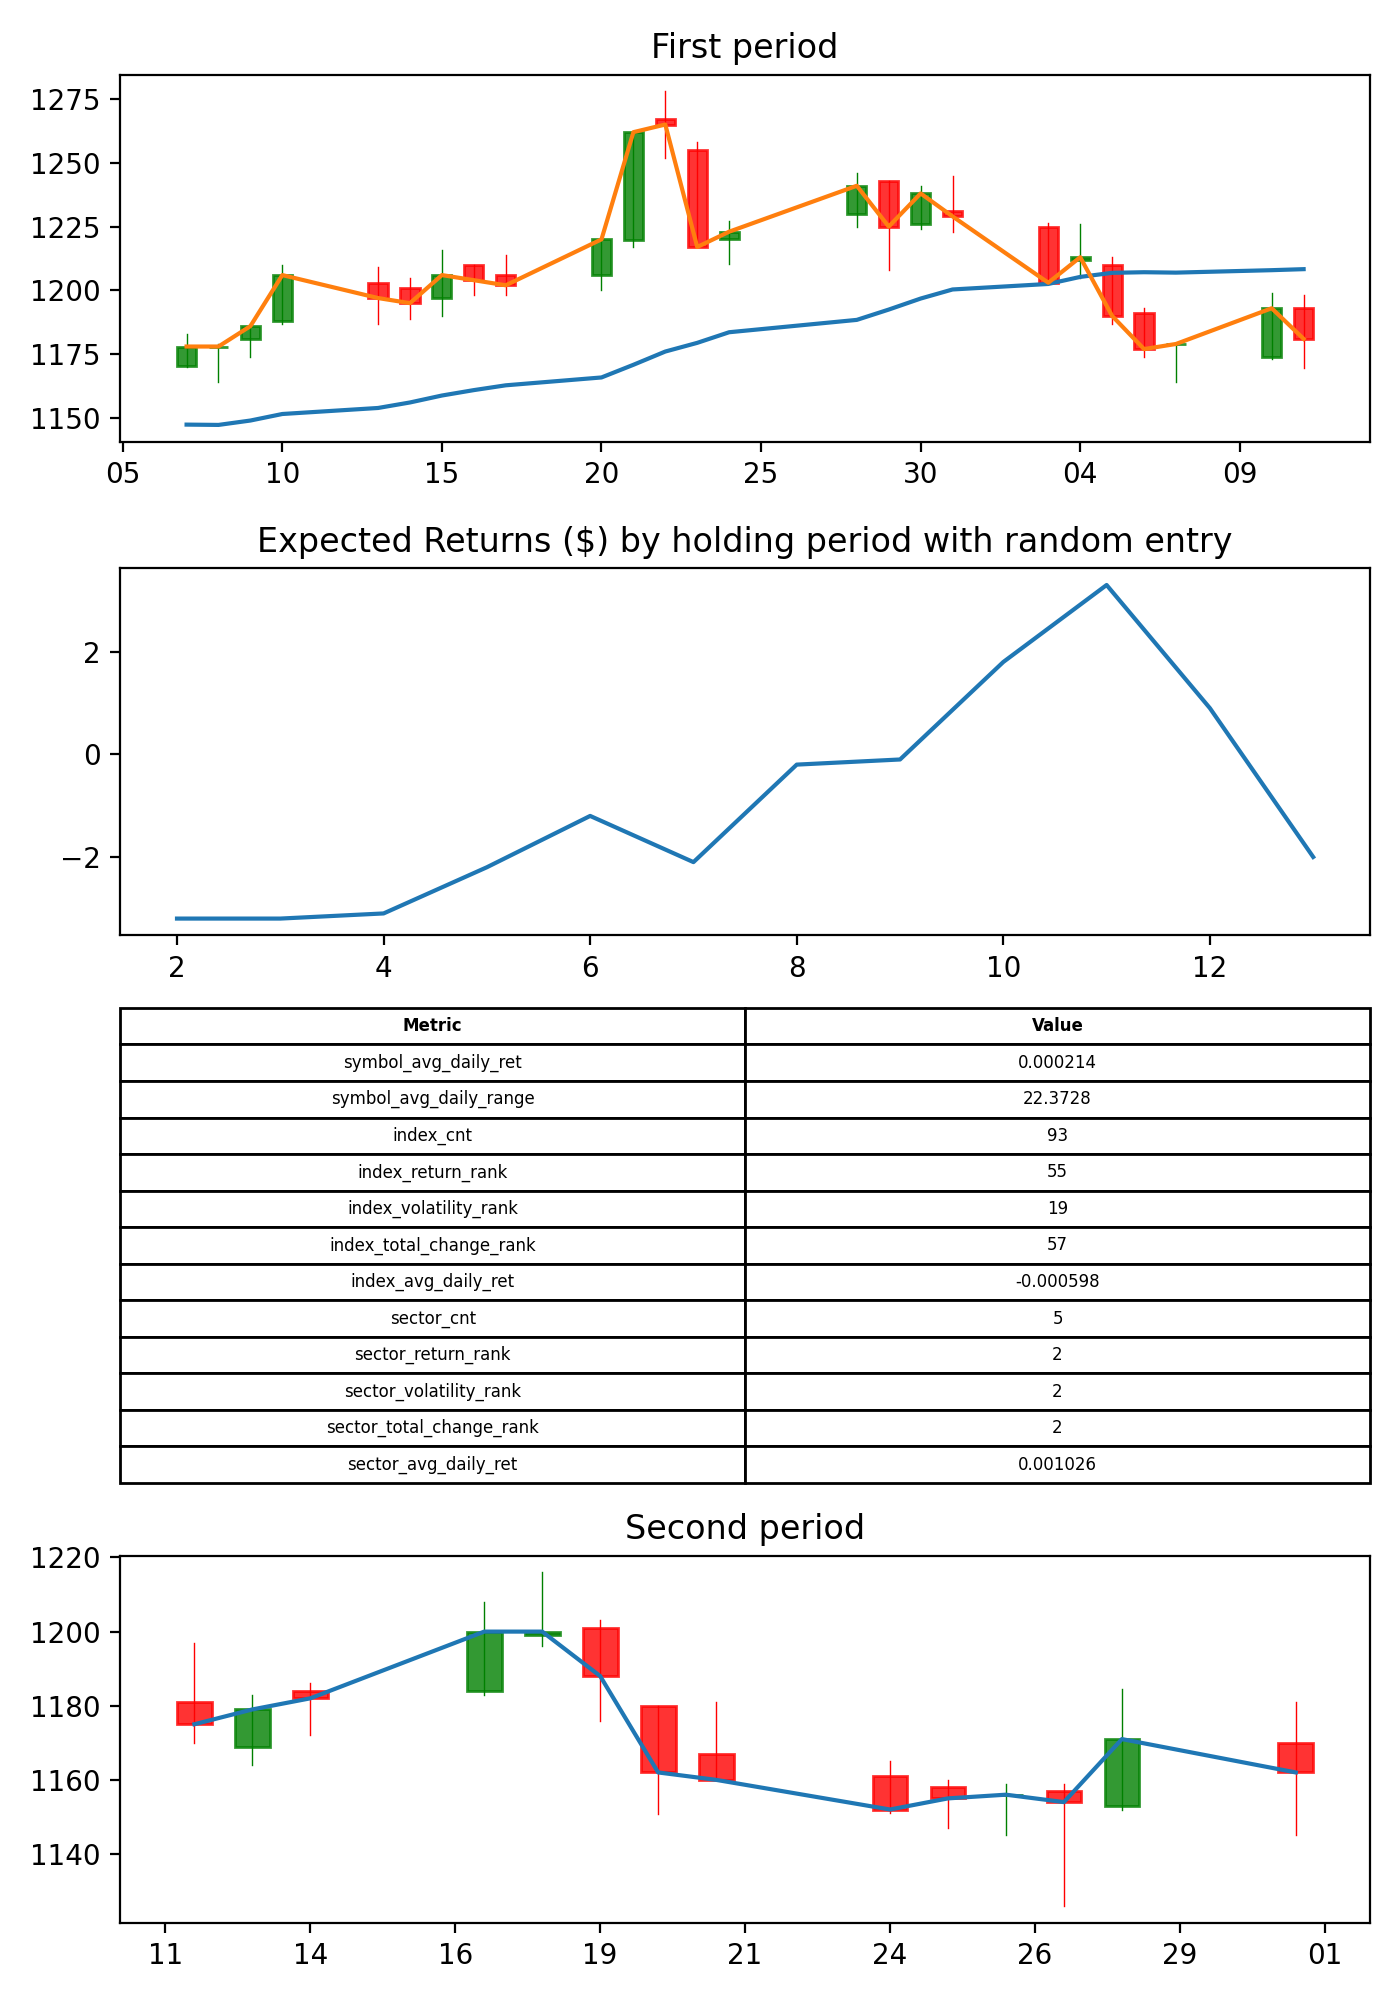

1st period:                open     high      low   close     volume     ma25
date                                                             
2013-05-07  1170.25  1183.00  1170.00  1178.0  2754521.0  1147.40
2013-05-08  1178.00  1179.00  1164.00  1178.0  1973242.0  1147.28
2013-05-09  1181.00  1187.00  1174.00  1186.0  1104812.0  1149.00
2013-05-10  1188.00  1210.00  1187.00  1206.0  3008974.0  1151.56
2013-05-13  1203.00  1209.00  1187.00  1197.0  1778120.0  1153.92
2013-05-14  1201.00  1205.00  1188.62  1195.0  2825918.0  1156.08
2013-05-15  1197.00  1216.00  1190.03  1206.0  2497994.0  1158.80
2013-05-16  1210.00  1210.00  1198.00  1204.0  1785140.0  1160.92
2013-05-17  1206.00  1214.00  1198.38  1202.0  2517781.0  1162.80
2013-05-20  1206.00  1221.00  1200.00  1220.0  2002555.0  1165.88
2013-05-21  1219.63  1262.00  1217.00  1262.0  3809837.0  1170.84
2013-05-22  1267.00  1278.00  1252.00  1265.0  2552925.0  1176.04
2013-05-23  1255.00  1258.03  1217.00  1217.0  3323395.0  1179.4

{'signal': 0,
 'profit': -9.03,
 'score': 0.7627090909090909,
 'hold': 3,
 'sl_hit': 0,
 'hold_hit': 0,
 '2nd_period':               open     high      low   close     volume     ma25
 date                                                            
 2013-06-12  1181.0  1197.00  1170.00  1175.0  2009887.0  1208.20
 2013-06-13  1169.0  1183.00  1164.00  1179.0  1621397.0  1208.24
 2013-06-14  1184.0  1186.00  1172.00  1182.0  1358557.0  1208.08
 2013-06-17  1184.0  1208.00  1183.00  1200.0  1742563.0  1207.84
 2013-06-18  1199.0  1216.00  1196.00  1200.0  1576510.0  1207.96
 2013-06-19  1201.0  1203.00  1176.00  1188.0  2041498.0  1207.68
 2013-06-20  1180.0  1180.00  1150.72  1162.0  3457301.0  1205.92
 2013-06-21  1167.0  1181.00  1160.00  1160.0  3248264.0  1204.16
 2013-06-24  1161.0  1165.00  1151.00  1152.0  2226563.0  1202.16
 2013-06-25  1158.0  1160.00  1147.00  1155.0  2097409.0  1199.56
 2013-06-26  1156.0  1159.00  1145.00  1156.0  2861733.0  1195.32
 2013-06-27  1157.0  115

In [1130]:
adhoc_random_trade_decision(
    universe=new_universe,
    lf=14,
    trade=True
)

In [1086]:
trade_res = adhoc_random_trade_decision(
    universe=new_universe,
    lf=14,
    show_metrics=False,
    trade=True
)

print(trade_res)

{'signal': 1, 'profit': 67.64670000000001, 'score': 1.7934615384615387, 'hold': 13, 'sl_hit': 0, 'hold_hit': 1, '2nd_period':               open    high     low   close     volume      ma25
date                                                           
2015-05-12  438.39  448.35  438.39  440.38  1869145.0  455.5888
2015-05-13  444.57  460.31  440.38  456.82  1308374.0  456.2064
2015-05-14  461.20  463.80  450.44  459.81  1519051.0  457.1988
2015-05-15  460.01  467.07  457.64  461.50   921139.0  458.7012
2015-05-18  465.59  470.57  443.97  447.16  1070060.0  459.0960
2015-05-19  446.36  451.34  443.47  446.36   510980.0  459.0324
2015-05-20  447.26  451.34  435.80  445.36   869506.0  459.0204
2015-05-21  443.37  443.37  427.73  433.61  1754121.0  458.5184
2015-05-22  440.00  470.20  438.00  456.00  2059509.0  459.1512
2015-05-26  461.80  469.90  450.30  460.00  1909490.0  459.9916
2015-05-27  461.70  468.75  457.90  467.40  1455241.0  460.9448
2015-05-28  469.60  476.10  464.70  469.00

In [1141]:
def _enter_res_dict(d, idx, trade_res):
    d[idx] = {
        'df': trade_res['2nd_period'],
        'hold': trade_res['hold'],
        'sl_hit': trade_res['sl_hit'],
        'hold_hit': trade_res['hold_hit'],
        'profit': trade_res['profit'],
        '1st_period_avg_range': trade_res['1st_period_avg_range'],
        'max_hold': trade_res['max_hold']
    }


k = 1000

labels = ('profit', 'score', 'signal', 'hold', 'sl_hit', 'hold_hit')
test_trades_results = {l: [] for l in labels}

false_positives = {}
true_positives = {}
label_for_signal = 1

print('Generating sample...')
t1 = time.time()
for idx, n in enumerate(range(k)):
    # print(f'Iteration no: {n+1}')
    trade_res = adhoc_random_trade_decision(
        universe=new_universe,
        lf=14,
        show_metrics=False,
        trade=True
    )
    for lab in labels:
        test_trades_results[lab].append(trade_res[lab])
    if (n/100).is_integer():
        print(f'... processing ({n+1}/{k})')
        
    if (trade_res['signal'] == label_for_signal) and (trade_res['profit'] < 0):
        _enter_res_dict(false_positives, idx, trade_res)
    elif (trade_res['signal'] == label_for_signal) and (trade_res['profit'] > 0):
        _enter_res_dict(true_positives, idx, trade_res)
        
        
print('... Sample is created')
t2 = time.time()
print(f'Took: {(t2-t1)/60} m')
df = pd.DataFrame(test_trades_results)


Generating sample...
... processing (1/1000)
... processing (101/1000)
... processing (201/1000)
... processing (301/1000)
... processing (401/1000)
... processing (501/1000)
... processing (601/1000)
... processing (701/1000)
... processing (801/1000)
... processing (901/1000)
... Sample is created
Took: 3.540092635154724 m


In [1142]:
def score_classifier(row):
    if row['score'] < 1:
        return '[0-1)'
    elif row['score'] < 2:
        return '[1-2)'
    elif row['score'] < 3:
        return '[2-3)'
    elif row['score'] < 4:
        return '[3-4)'
    elif row['score'] < 5:
        return '[4-5)'
    elif row['score'] < 6:
        return '[5-6)'
    elif row['score'] < 7:
        return '[6-7)'
    elif row['score'] < 8:
        return '[7-8)'
    elif row['score'] < 9:
        return '[8-9)'
    elif row['score'] < 10:
        return '[9-10)'
    else:
        return 'inf'
    
df['score_class'] = df.apply(score_classifier, axis=1)
df

,profit,score,signal,hold,sl_hit,hold_hit,score_class
0,55.5207,3.856108,1,13,0,1,[3-4)
1,-52.0000,0.011700,1,2,0,1,[0-1)
2,-63.0236,0.627810,-1,2,0,1,[0-1)
3,187.6476,3.346583,1,11,0,0,[3-4)
4,-32.2020,0.190750,1,2,0,0,[0-1)
...,...,...,...,...,...,...,...
995,-63.7980,1.198885,1,3,0,0,[1-2)
996,-26.7581,0.881346,1,4,0,0,[0-1)
997,-56.2680,5.894400,-1,2,0,1,[5-6)
998,-62.9860,1.330769,1,2,0,0,[1-2)


<IPython.core.display.Javascript object>


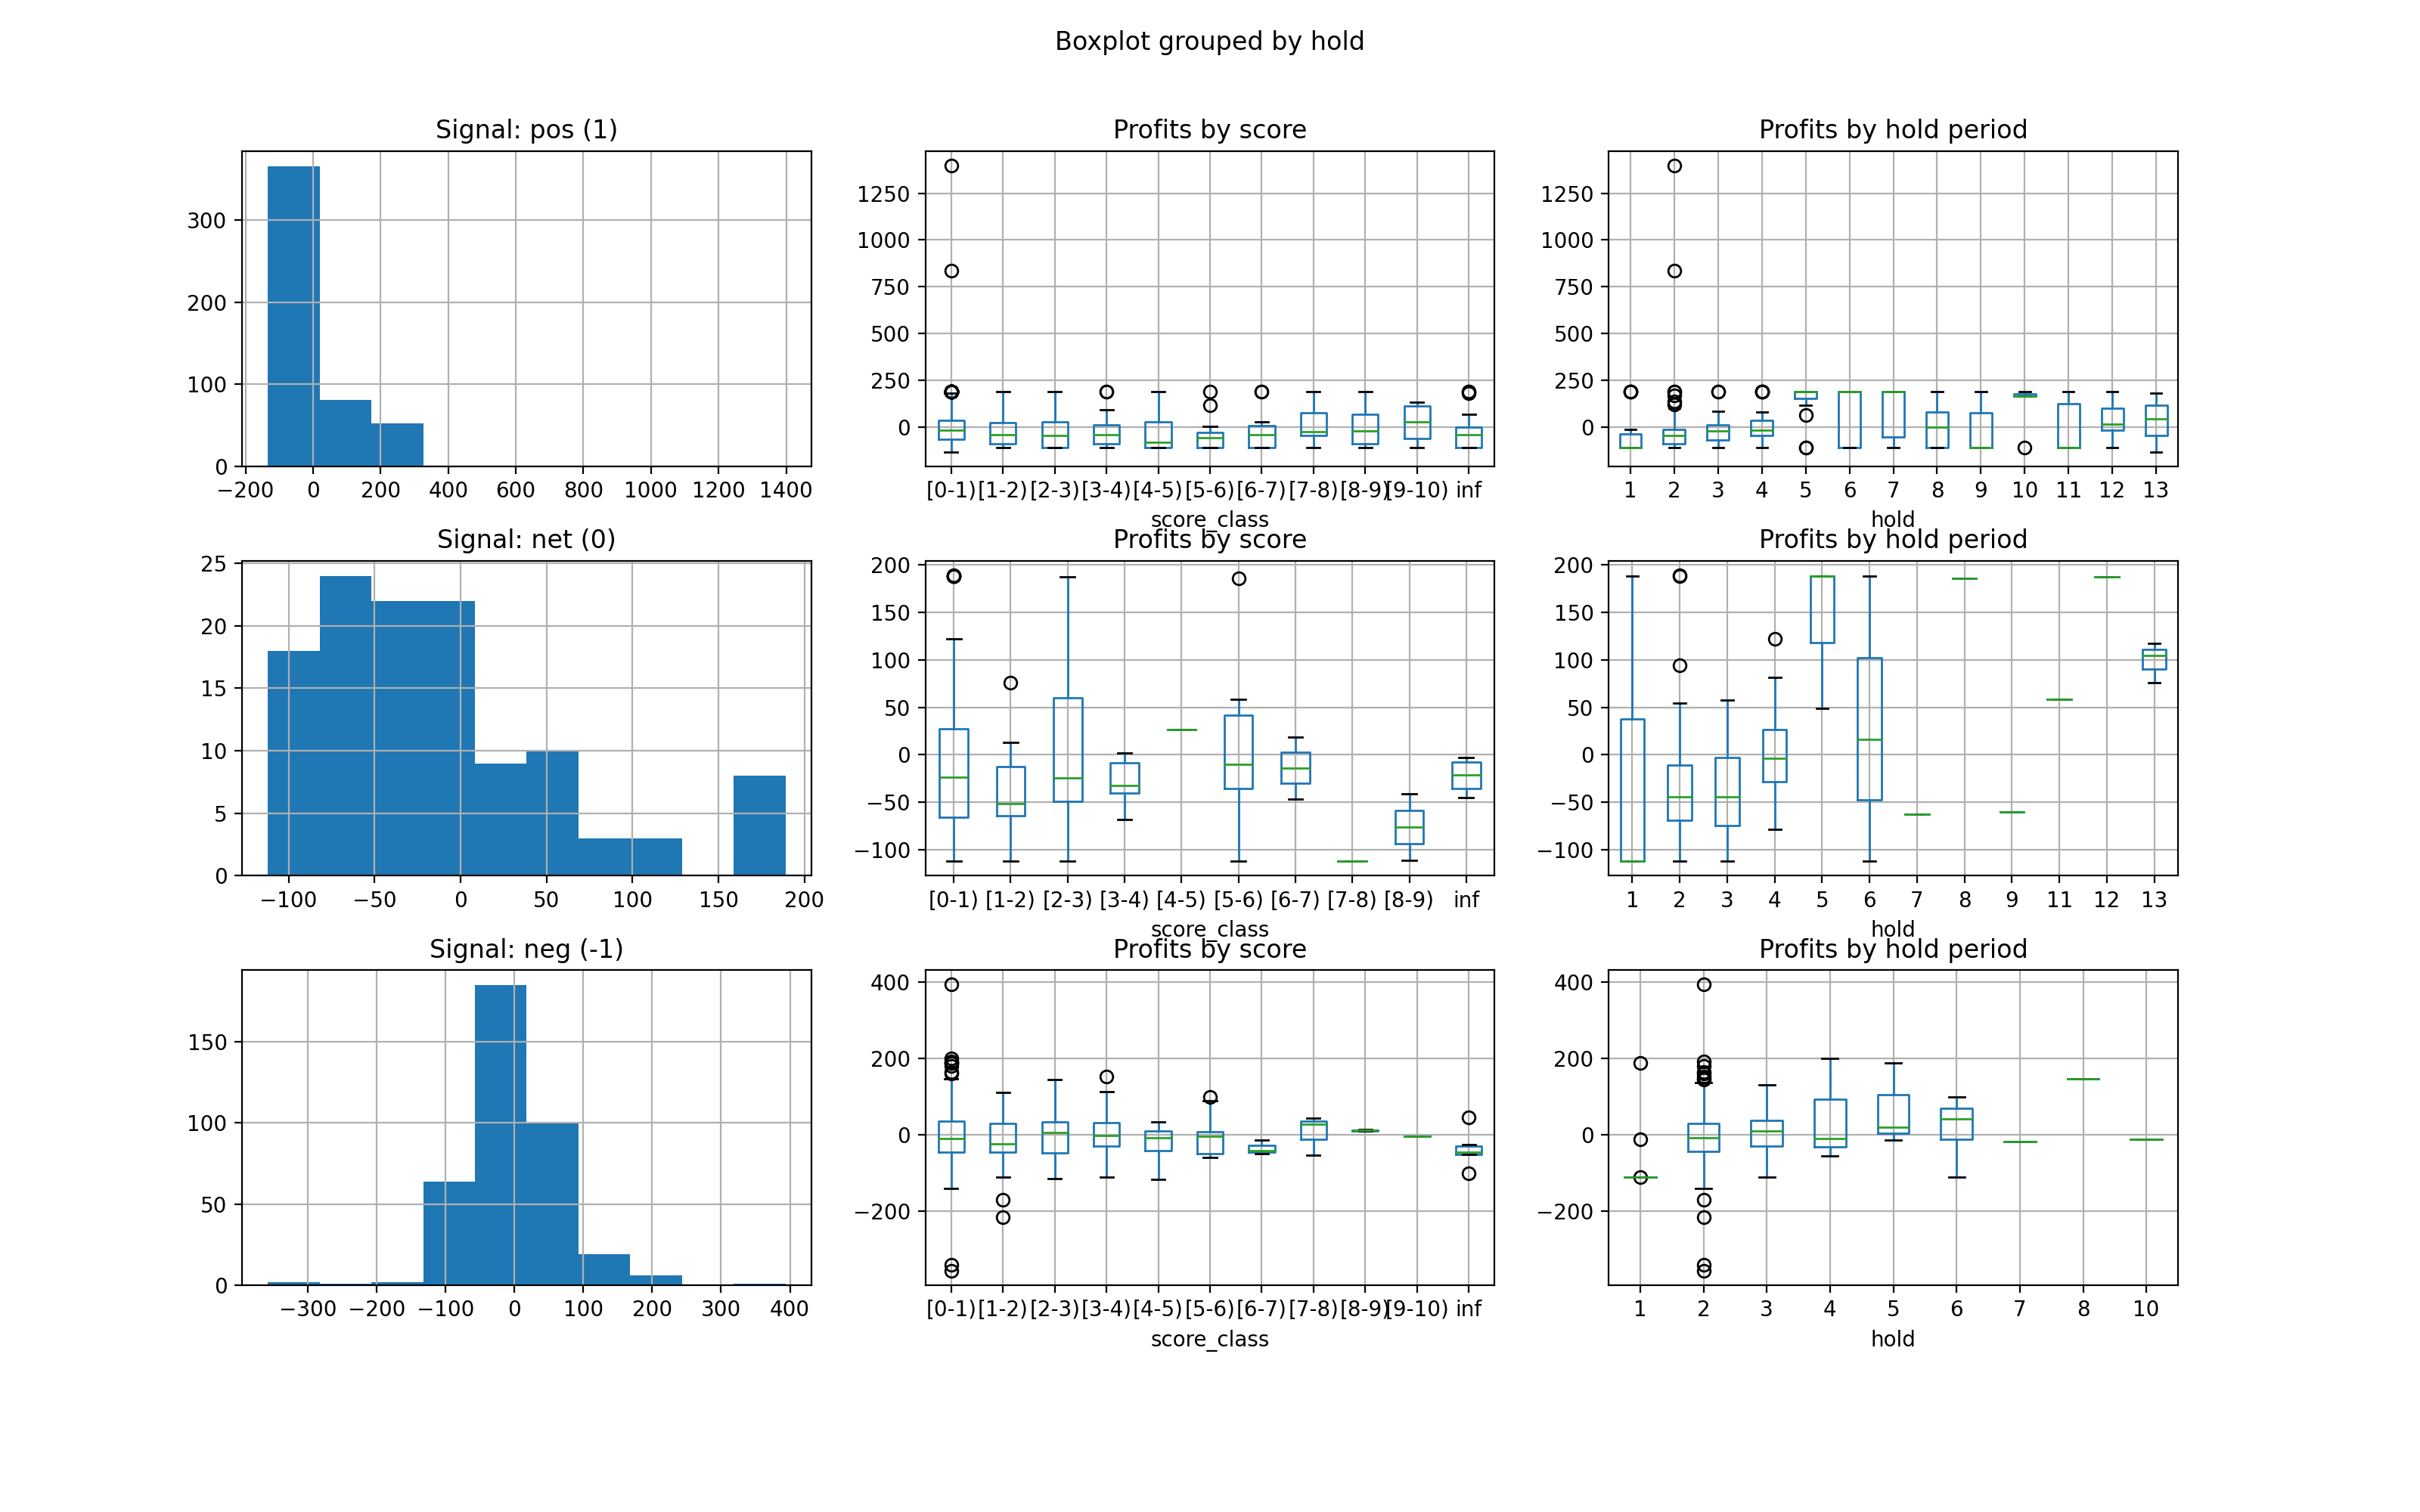

In [1143]:
def dists_by_signal(df):
    """
    Distributions by trends
    """

    trends = [('pos (1)', 1), ('net (0)', 0), ('neg (-1)', -1)]
    fig, ax = plt.subplots(len(trends), 3, figsize=(16,10))
    
    for idx, trend_tpl in enumerate(trends):
        trand_label, trend = trend_tpl
        data = df[df['signal'] == trend]
        # Profits
        data.hist(
            column='profit',
            ax = ax[idx,0],
        )
        ax[idx,0].set_title(f'Signal: {trand_label}', loc='center')
        # Scores
        data.boxplot(
            ax=ax[idx,1],
            by='score_class',
            column='profit',
        )
        ax[idx,1].set_title('Profits by score', loc='center')
        # Realized hold period
        data.boxplot(
            ax=ax[idx,2],
            by='hold',
            column='profit',
        )
        ax[idx,2].set_title('Profits by hold period', loc='center')


dists_by_signal(df)


"""
Breakdowns for analysis:
- trend (-1, 0, 1)
    Expected: better profits on 1s
    NOT MET
- score
    Expected: better profits on high scores
        - Met for 0 till ~6
        - For 1 distribution gets wider with higher score
        - For -1
- holding period
    No expectations...
        - No obvious insights
""";

In [1149]:
sum(df[df['signal'] == 1]['profit'])

-4301.888381999999

In [692]:

# how many times I had loss due to max_hold period (on signal=1, which in theory is rising trend)
# what were those holding times?
# vs. how many times due to SL hit

df_trend_1 = df[df['signal'] == 1]

print('pos trend cnt: ', df_trend_1.shape[0])

pos_prof = df_trend_1[df_trend_1['profit'] > 0]

print('cnt pos profit: ', pos_prof.shape[0])
print('neg profit cnt: ', df_trend_1.shape[0] - pos_prof.shape[0])

print('sl hit cnt: ', df_trend_1[df_trend_1['sl_hit'] == 1].shape[0])
print('hold hit cnt: ', df_trend_1[(df_trend_1['hold_hit'] == 1) & (df_trend_1['profit'] < 0)].shape[0])

# ~30% SL hit...





pos trend cnt:  492
cnt pos profit:  232
neg profit cnt:  260
sl hit cnt:  81
hold hit cnt:  178


In [693]:
# From bad trades that hit max trade hold, what is the dirstribution of realised hold days?
df_trend_1[(df_trend_1['hold_hit'] == 1) & (df_trend_1['profit'] < 0)].groupby(['hold']).count()


,profit,score,signal,sl_hit,hold_hit,score_class
hold,,,,,,
2,34,34,34,34,34,34
3,1,1,1,1,1,1
5,1,1,1,1,1,1
6,2,2,2,2,2,2
7,3,3,3,3,3,3
8,1,1,1,1,1,1
9,5,5,5,5,5,5
10,9,9,9,9,9,9
11,5,5,5,5,5,5


In [694]:
# From bad trades that hit SL, what is the distribution of days they hit SL?
df_trend_1[(df_trend_1['sl_hit'] == 1) & (df_trend_1['profit'] < 0)].groupby(['hold']).count()


# Can I guess earlier that trade will go in wrong direction. Or cut losses earlier?
# E.g. if I see hold period already at ~5 but there is opposite direction?


,profit,score,signal,sl_hit,hold_hit,score_class
hold,,,,,,
1,1,1,1,1,1,1
2,6,6,6,6,6,6
3,5,5,5,5,5,5
4,9,9,9,9,9,9
5,7,7,7,7,7,7
6,10,10,10,10,10,10
7,8,8,8,8,8,8
8,11,11,11,11,11,11
9,7,7,7,7,7,7


In [695]:
for idx in sorted(list(false_positives.keys())):
    print(idx)

1
3
8
12
13
15
22
24
28
29
34
37
44
46
52
58
68
71
77
85
87
89
90
94
96
98
104
106
107
114
115
117
118
122
124
129
130
132
133
134
140
145
146
148
150
156
160
162
163
168
170
173
177
178
183
187
192
194
202
203
208
214
228
230
231
239
240
242
244
252
266
267
269
273
275
277
280
281
288
292
293
295
296
308
311
323
330
331
334
340
347
351
354
355
359
366
368
370
371
372
388
394
396
397
399
406
407
408
409
411
414
415
417
418
421
426
428
429
430
432
434
440
443
449
451
454
466
487
495
502
507
514
516
525
527
530
531
539
541
546
554
559
561
562
563
566
568
571
575
579
581
584
590
595
605
612
614
617
618
620
621
622
627
629
631
634
637
649
652
653
654
655
657
658
661
666
667
669
670
671
674
675
677
683
685
690
692
694
698
699
702
721
726
730
733
734
736
743
745
747
752
754
760
765
766
770
771
776
782
783
797
804
816
817
824
828
829
830
834
836
846
854
856
857
865
876
879
880
883
885
892
898
901
903
904
907
908
909
912
913
915
916
920
922
923
925
929
930
931
933
935
955
961
963
972
973
979
9

<IPython.core.display.Javascript object>


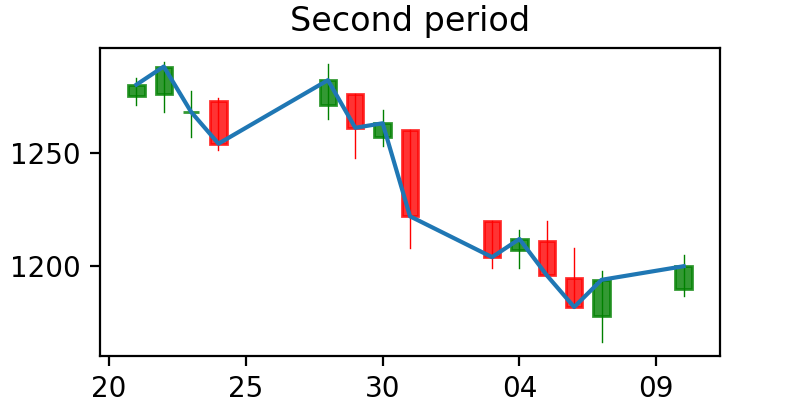

Realized hold: 9
SL hit?:  1
Max. hold hit?:  0


In [613]:
def show_2d_period_only(second_period):
    fig, ax = plt.subplots(1, 1, figsize=(4,2))
    ohlc_2nd = prep_df_to_ohlc(second_period)
    candlestick_ohlc(ax, ohlc_2nd.values, width=0.6, colorup='green', colordown='red', alpha=0.8)
    ax.plot(ohlc_2nd['date'], second_period['close'].tolist())
    date_format = mpl_dates.DateFormatter('%d')
    ax.xaxis.set_major_formatter(date_format)
    ax.set_title('Second period', loc='center')

test_idx = 22
show_2d_period_only(
    false_positives[test_idx]['df']
)
print('Realized hold:', false_positives[test_idx]['hold'])
print('SL hit?: ', false_positives[test_idx]['sl_hit'])
print('Max. hold hit?: ', false_positives[test_idx]['hold_hit'])


In [ ]:
"""
Analysing cases where my entry was wrong ( I will have to do the same with with "winning" trades)
4.
    - Started with big drop (day 2 and 3, two big red candles)
    - Rest of the days was a recovery. Did not managed to fully recover though due to Max. Hold period
    - If help longer ~2day I'd be neutral or even small win
16.
    - Started with drop. Initial 2 red candles (with big lows, but without hitting SL)
    - Losses lasted pretty much ~6-7 days
    - Slow recovery after this. Hold was 12d. It was not enough to recover though
21.
    - Frist day red canlde (drop), next 2 days small green candles (growth about first day loss)
    - Serioes of losses after this. 1 very large red canlde that if sold on open could lead to small profit
    - Gain was not enough to hit exit. After max hold period selling on close which leeds to loss
24.
    - Started with 3 red canldes. In general horizontal move though
    - Sell is on 5th day (max hold) which was still on loss
    - After my sell there is ver nice and long serioes of green canddles. Could be profit
29.
    - First day close without price change. Then 2 big red candles
    - Rest of the days recovery
    - Holding period was long (~13d) and it almost managed to recover from initital loss
30.
    - First 2 days loss (2 not big red cnadles)
    - After small loss, 10 days of uptrend. Not catching it as hold period was 2
34.
    - 2 days of losses (normal size red candles)
    - next ~8days i growth that fully recovers initial loss
    - Another drop after this (similar to the initial one)
    - Hold period was 13 days and initial loss recovered...
    - ... but as price did not incresed to exit I've "cought" next drop and exited on it
39.
    - 2 days of losses (normal size red candles)
    - Next 12ds is pretty much stable growth. Did not hit this as Max. Hold. was only 2d
46.
    - 5days of relatively stable growth. not hitting exit price though
    - on 6d big red candle (without touching SL)
    - Rest days is horizontal move. after 13 I'm exiting on the level from big drop
62.
    - 3 days of gorwth at the begining
    - Followed by ~8day of pretty stable decrease
    - Did not hit SL but exiting after 11 days at the bottom
63.
    - 2 first days red candles (open pirces grows though)
    - After this pretty stable downtrend
    - Exiting after 13 day at the bottom. SL was not hit as drop was not that sharp
64.
    - 2 days of growth. Small one though. Did not accomodate for fees
    - Max. hold period very small (2days), so exiting
    - After my exit stable uptrend. Could be bigger win I hold longer
80.
    - First 6th candles is growth (with only 2nd candle being red). Not able to hit exit though
    - After this drop below entry (3 days relativlely sharp downfall)
    - Then up again. Exiting after 13 days which is recovery after drop. So no gain
91.
    - First day small loss, then stable big uptrend. It was almost perfect timing
    - Loss is due to Max Hold which was only 2d
95.
    - Start with loss (3 red candles)
    - Rest of days recovery. After 12d exit. Did not managed to recover.
    - Could end up neutrally if exit earlier (there was one high close price to entry)
99.
    - First day loss. The nice uptrend
    - Did not managed to hit exit though. Last couple of ddays is sharp drop. 
    - Exiting after the end of period drop
112.
    - Starts with 3d of losses. Small reconvery after that followed by more losses
    - In general, pretty stable down trend. Exit from it on 13d max hold
    - Loss did not triggered SL
122.
    - Starts with 2 days of losses. Then more stable losses (downtrend)
    - Exits on short (2d) max hold
123.
    - Start with 1d red candle, but then sequence of green recoveries
    - In general horizontal move
    - Last day of period big green candle, but not catching it as exiting earlier
    - Max hold was long (13d). This trade had samll loss
131.
    - Start with 1d red candle, but then sequence of green uptrend
    - Could be good win but short (2d) max hold stopped it
133.
    - Starts with 4d of red candles losses
    - Exits on 2d day with max hold. It was good as trend was pretty much on downtrend
134.
    - Starts with 3d of small red candles (almost horizontal move)
    - Followed by 1d of big green candle. Downtrend after that
    - Closes after 10d max hold on loss
    
    
31.
    - 6 days of consequitive losses
    - 6th days loss was so big that it hits SL
43.
    - 6 days of consequitive losses
    - 6th days loss was so big that it hits SL
    - If I do NOT exit, there will be just more losses
50.
    - First day close without price change.
    - Next 4 days constant loss. With bir red candle at the end of the 4th day
    - SL hit. there will be horizontal/slight downtrend move after this anyway
55.
    - 1st day relative big loss (red candle)
    - Next 4 days there is increase but very small candles. Can not recover in this time.
    - Downtrend after this. SL hit. More decrease after my exit anyway.
65.
    - Start 5 big candels downs 
    - On 3rd already hit SL. Horizontal move after going down
61.
    - Start with stable downtrend (for ~8 days)
    - Hits SL already at 9th (which is btw first day of smaller uptrend
    - but there would not be recovery anyway
81.
    - First 5 days is pretty much horizontal move (with ~red/green/red... candles)
    - Big red candles after this. To the point of hitting SL (on 8day)
    - After my exit horizontal move at the bottom
83.
    - Start with 1 small green candle. Followed by 3 big moves down
    - To the point that SL is hit on day 4
    - 5th day (after exit) is big move up but anyway
    - can't fully recover and continues hirizontal after
115.
    - Start with 3d of small losses. Then, on 4th day there is big red candles
    - Stable downtrend. Exit at 8th day by SL hit
""";

In [614]:
for idx in sorted(list(true_positives.keys())):
    print(idx)

5
6
13
16
18
19
21
23
24
26
28
31
32
34
39
41
47
51
55
62
63
65
73
77
79
82
85
86
87
103
106
116
123
126
130
131
139
141
143
146
148
154
166
170
176
179
181
188
189
192
193
194
201
202
206
216
218
220
223
224
231
240
245
246
249
255
256
259
261
265
266
267
269
275
283
285
290
292
299
310
311
312
317
322
327
328
330
342
348
358
363
372
373
375
376
379
381
384
389
390
391
394
397
398
411
420
421
423
435
440
445
449
450
456
466
467
469
471
472
484
485
489
493
496
498
501
504
506
509
518
519
523
525
531
534
535
539
543
548
553
554
559
562
565
569
570
575
577
580
590
596
599
602
608
609
612
615
621
625
626
630
635
637
639
640
642
643
658
660
664
665
678
682
687
688
694
699
703
704
705
709
717
722
727
730
732
733
735
736
742
750
751
753
755
758
760
761
773
780
786
797
798
802
814
821
823
831
836
837
871
872
873
885
888
890
893
896
907
908
909
911
916
924
929
933
935
940
941
948
953
955
956
965
969
977
982
983
990
994


<IPython.core.display.Javascript object>


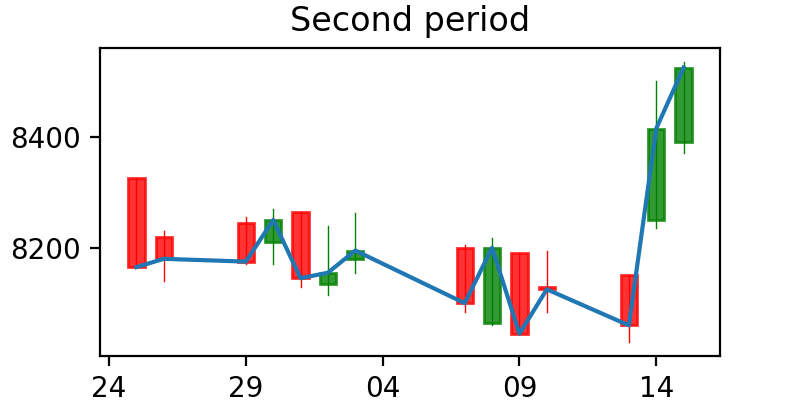

Realized hold: 13
Max. hold hit?:  1
Profit:  9.600000000000001


In [625]:
test_idx = 6
show_2d_period_only(
    true_positives[test_idx]['df']
)
print('Realized hold:', true_positives[test_idx]['hold'])
print('Max. hold hit?: ', true_positives[test_idx]['hold_hit'])
print('Profit: ', true_positives[test_idx]['profit'])

In [ ]:
"""
# Profitable traddes analysis:

6.
    - Starts with 3 green candles, then horizontal move leading to downtrend
    - Max. hold was 2d so it managed to take profit
7.
    - Starts with 3 green candles, then correction to same level, followed by nice uptrend
    - Profit taken on 2d after hitting exit
    - If kept longer (e.g. 6d) there would be loss
    - Profit could be higher in this case if kepr for >8d
8.
    - Starts with 3 green candles, then then horizontal move leading to bigger uptrend
    - Profit taken on 3rd after hitting exit
    - Profit could be higher in this case if kepr for >8d
15.
    - Starts with green|red|green (small uptrend ignoring ranges)
    - Then more mixed uptrend. Exiting at 7d from hitting exit
    - That was perfect exit as next day was start of sharp and big downtrend
18.
    - Starts with 2 green candles. Exiting at 3rd after hitting exit
    - Good decision as 3rd day ended up red. Downtrend for rest of the period
22.
    - Starts with green|red|red, then nice uptrend
    - Exit at 8d (no max hold) with profit
    - Keeping longer would not be a good idea
    

    
""";

In [44]:
"""
If you want to look at short term gain (matter of days) you cannot ignore intraday swings.
High|low price is must know for you. E.g. if you set-up stop loss, you can easily get wiped out by
quick move down. On the other hand, quick rally-up can satisfy you as well.

While enternig a trade you need to define both exit levels (SL exit, good exit). Those levels can be adjusted 
during the trade in some scenarios. E.g.:
    - For example, let's say that trade went your way and you hit good exit price. You can keep holding and see if 
    more gains can be sqeezd by modifyinig SL to good exit price. Then modify holding period or set new price level.
    - Scaling SL: one strategy is to adjust a SL as soon as price goes in right direction the way that you break
    even in case in turn to be wrong. Seems like good idea but may be hard to backtest with daily data... 
    
In general, you need yo be more dynamic while entering the trade. Having hard constraints, like hold X day, enter
or exit on x%, always enter/exit near the end of day (close price) etc. is too crude and naive.

At the end, what will matter is to have enough opportunities and resonable expected returns in the long run.
You will be able to scale over time with this.


Input parameters:
- entry decision
- initial SL level
- initial exit level
- iniitial holding period






"""


"""
Rzeczy na ktora patrze jako czlowiek:
1. Ile mozna bylo zarobic w ostatnim okresie trzymajc X dni?

Zalozenie: Podobnie jak w pasywnym inwestowaniu, patrze ile mozna bylo zarobic historycznie. Jezeli performance
jest dobry, zakladam ze mozliwe jest ze przez najblizszy okres wciaiz bedzie ok.

Nibespieczenstwa:
- Reversal (bylo dobrze alo to byla koncowka trendu)
- Missed opportunity (ostatni okres byl zly ale teraz wsakuje na dobre tory)

Teoretycznie sentiment data mogloby pomoc (np. dobry okres wg. ceny ale sentyment zly -> nie wchodz)

~Zasady:
+ Jezeli ~5-10dni mozna bylo zarobic to dobry znak
- Jezeli w ostatnim okresie moglem stracic - zly znak

2. Jak sobie radzi symbol w porownaniu z innymi w indeksie/sektorze?

Zalozenie: Chce inwestowac w lepszych. Zakladajac ze ten kto lepiej sobie radzi - bedzie tak kontynuowal

Niebezpieczenstwa:
Tak samo jak w 1. Bardziej generalnie, czy moje zalozenia sa ok dla relatywnie krotkiego okresu wachania ceny?

3. Jak dlugo cena jest ponad srednia i jaki jest trend?

E.g. cena idzie horyzontalnie ale jest caly czas nad MA ktore powoli dobija od dolu.
To by wsakzywalo na to ze pooprzednio byl wzrostowy ale teraz cos sie zablokowalo
""";

In [239]:
# Volatility is a rate at which the price increases|decreases for a given set of returns

"""
SL -> -1.5 avg. daily range
Exit -> +1.5 avg. daily range
Max hold period -> Max. expected return from random entry
When Exit reached -> Adj. SL to Exit price (hold till the end of given day)


"""





"""
Possible factors:
Decide on entry:
    - general trend
    - days over/under mean price

Decide ~RRR equivalent (-> which trade is better?) 
- daily range (how big daily swings one can expect)
- exit price (expected gain)
- max hold period (waiting time to realize gain)



Jezeli przyjme zarowno SL (Stop Loss) jak i EL (Exit Level) jako taki sam, to RRR bedzie zawsze 1...
Jak wtedy ocenic oplacalnosc? 
E.g:
- Wielkosc ruchu
    - Moze faworyzowalo te z duzymymi wachaniami. Czy to jest to czego chce?
- Czas w jakim bedzie on zrealizowany
    - Short va. Long holding period
    - Moze polaczenie e.g. MAXIMIZE -> potencjany_zysk/max_holding
- % positive results based on random period
    - Zakladajac ze nie ma totalnej zmiany nastrojow, ~ prawdopodobienstwo wyjscia na zero albo zysku
    
Initial metric candidates:
- (potential_gain / max_holding) * P(positive_result_from_rand_entry)

- Entry signal?

How to test?
- Based on entry signal, see the distribution of results by their scores.
- Desired behaviour is to have higher results on trades with higher score
- and lower results on trades with lower score
- If that is NOT the case.... Score does not work as it suppose to


""";

In [751]:
false_positives

{4: {'df':              open   high    low  close    volume    ma25
  date                                                    
  1990-07-27  208.0  208.0  206.5  208.0  221092.0  204.84
  1990-07-30  207.0  208.5  205.0  208.0  198012.0  205.00
  1990-07-31  208.0  209.5  207.5  209.0  160668.0  205.26
  1990-08-01  210.0  211.0  209.0  210.5   65458.0  205.72
  1990-08-02  209.0  210.5  206.5  207.5  145526.0  206.08
  1990-08-03  206.5  208.5  203.0  204.0   47242.0  206.38
  1990-08-06  202.0  202.0  198.0  199.5  329470.0  206.46
  1990-08-07  198.5  202.0  198.5  201.5  638268.0  206.46
  1990-08-08  201.0  201.5  200.0  201.0   18722.0  206.36
  1990-08-09  201.0  202.5  200.0  201.0  397736.0  206.20
  1990-08-10  202.0  202.0  200.0  201.0  165478.0  205.88
  1990-08-13  199.0  201.5  199.0  200.0  343580.0  205.62
  1990-08-14  202.0  202.0  200.0  201.0  415260.0  205.44
  1990-08-15  201.0  202.5  201.0  203.0  570948.0  205.32,
  'hold': 2,
  'sl_hit': 0,
  'hold_hit': 1,
 

In [878]:
"""
Monitor good/bad trade after entry to cut losses earlier

Start from taking bunch of features and drawing simple plots to see if there are clusters

1d features
- Candle color
- Candle size (relative to avg. range)
- % drop/increase



""";



In [857]:
from sklearn.model_selection import train_test_split
import random
from sklearn.naive_bayes import GaussianNB

In [1093]:
def get_1d_features(df=None, avg_range=None, max_hold=None):
    chg_1d = df.iloc[0]['close'] - df.iloc[0]['open']
    color = 1 if chg_1d > 0 else -1
    size_ratio = abs(chg_1d) / avg_range if avg_range > 0 else 1
    prc_chg = chg_1d / df.iloc[0]['open']
    duration_pct = (max_hold-1)/max_hold
    return [
        color,
        size_ratio,
        prc_chg,
        duration_pct,
    ]

features = []
labels = []
for d, lab in ((false_positives, -1), (true_positives, 1)):
    for ex_idx in d:
        features.append(
            get_1d_features(
                df = d[ex_idx]['df'],
                avg_range = d[ex_idx]['1st_period_avg_range'],
                max_hold = random.randint(1,13),
                # max_hold = d[ex_idx]['max_hold'],
            )
        )
        labels.append(lab)

features = np.array(features)
labels = np.array(labels)

train, test, train_labels, test_labels = train_test_split(
    features,
    labels,
    test_size=0.33
)

# Initialize our classifier
model_1d = GaussianNB()

# Train our classifier
model_1d.fit(train, train_labels)
;

# Predict
preds = model_1d.predict(test)
print(preds)

comp_lst = list(preds == test_labels)
print('all cnt:', len(comp_lst))
print('correctly classified overall', comp_lst.count(True))
print('accuracy total: ', round((comp_lst.count(True) / len(comp_lst))*100))

[ 1 -1 -1  1  1 -1 -1 -1  1 -1 -1 -1 -1  1 -1  1 -1 -1  1 -1  1 -1  1  1
  1  1 -1 -1  1  1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1  1 -1 -1 -1 -1  1  1
 -1 -1 -1 -1 -1 -1 -1  1 -1  1  1 -1 -1 -1  1  1 -1  1 -1 -1 -1  1 -1  1
 -1 -1  1 -1 -1 -1  1 -1 -1  1  1  1 -1 -1 -1 -1 -1  1  1 -1  1  1 -1  1
 -1 -1  1  1 -1  1 -1 -1  1  1 -1 -1 -1  1  1  1  1  1  1  1 -1 -1  1 -1
 -1 -1 -1  1  1 -1 -1 -1  1 -1  1 -1  1  1  1 -1  1 -1 -1  1  1 -1 -1  1
  1  1 -1 -1  1  1 -1 -1 -1 -1  1  1  1  1 -1  1 -1 -1  1 -1 -1  1 -1 -1
  1]
all cnt: 169
correctly classified overall 119
accuracy total:  70


In [1094]:
def get_2d_features(df=None, avg_range=None, max_hold=None):
    chg_1d = df.iloc[0]['close'] - df.iloc[0]['open']
    chg_2d = df.iloc[1]['close'] - df.iloc[1]['open']
    color_1 = 1 if chg_1d > 0 else -1
    color_2 = 1 if chg_2d > 0 else -1
    size_ratio_1d = abs(chg_1d) / avg_range if avg_range > 0 else 1
    size_ratio_2d = abs(chg_2d) / avg_range if avg_range > 0 else 1
    
    prc_chg = (df.iloc[1]['close'] - df.iloc[0]['open'])/ df.iloc[0]['open']
    duration_pct = (max_hold-2)/max_hold
    
    max_profit = (100 * ((df.iloc[1]['high'] - df.iloc[0]['open'])/100)) - 12 # 12 is fee, 100 is share cnt
    
    return [
        color_1,
        color_2,
        size_ratio_1d,
        size_ratio_2d,
        prc_chg,
        duration_pct,
        max_profit,
    ]

features = []
labels = []
for d, lab in ((false_positives, -1), (true_positives, 1)):
    for ex_idx in d:
        features.append(
            get_2d_features(
                df = d[ex_idx]['df'],
                avg_range = d[ex_idx]['1st_period_avg_range'],
                max_hold = d[ex_idx]['max_hold'],
            )
        )
        labels.append(lab)

features = np.array(features)
labels = np.array(labels)

train, test, train_labels, test_labels = train_test_split(
    features,
    labels,
    test_size=0.33
)

# Initialize our classifier
model_2d = GaussianNB()

# Train our classifier
model_2d.fit(train, train_labels)
;

# Predict
preds = model_2d.predict(test)
print(preds)

comp_lst = list(preds == test_labels)
print('all cnt:', len(comp_lst))
print('correctly classified overall', comp_lst.count(True))
print('accuracy total: ', round((comp_lst.count(True) / len(comp_lst))*100))

[-1 -1 -1  1 -1 -1 -1  1  1  1 -1 -1  1  1 -1 -1 -1 -1  1 -1 -1 -1  1 -1
 -1 -1 -1 -1  1 -1  1 -1 -1 -1 -1 -1 -1  1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1
 -1  1 -1 -1 -1  1  1 -1 -1  1 -1 -1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1
  1 -1  1 -1  1 -1 -1 -1  1  1  1 -1 -1  1  1 -1 -1  1 -1  1 -1  1 -1 -1
 -1 -1 -1  1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1  1  1  1 -1  1  1  1 -1  1  1 -1 -1  1 -1 -1  1 -1 -1  1 -1 -1 -1  1
  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1  1
 -1]
all cnt: 169
correctly classified overall 130
accuracy total:  77


In [1101]:
def get_3d_features(df=None, avg_range=None, max_hold=None):
    chg_1d = df.iloc[0]['close'] - df.iloc[0]['open']
    chg_2d = df.iloc[1]['close'] - df.iloc[1]['open']
    chg_3d = df.iloc[2]['close'] - df.iloc[2]['open']
    color_1 = 1 if chg_1d > 0 else -1
    color_2 = 1 if chg_2d > 0 else -1
    color_3 = 1 if chg_3d > 0 else -1
    size_ratio_1d = abs(chg_1d) / avg_range if avg_range > 0 else 1
    size_ratio_2d = abs(chg_2d) / avg_range if avg_range > 0 else 1
    size_ratio_3d = abs(chg_3d) / avg_range if avg_range > 0 else 1
    
    prc_chg = (df.iloc[2]['close'] - df.iloc[0]['open'])/ df.iloc[0]['open']
    duration_pct = (max_hold-3)/max_hold
    
    profit = chg_1d + chg_2d + chg_3d
    
    lowest = min(df.iloc[0]['low'], df.iloc[1]['low'], df.iloc[2]['low'])
    highest = min(df.iloc[0]['high'], df.iloc[1]['high'], df.iloc[2]['high'])
    
    return [
        color_1,
        color_2,
        color_3,
#         size_ratio_1d,
#         size_ratio_2d,
#         size_ratio_3d,
        prc_chg,
        duration_pct,
        profit,
        lowest,
        highest
    ]

features = []
labels = []
for d, lab in ((false_positives, -1), (true_positives, 1)):
    for ex_idx in d:
        features.append(
            get_3d_features(
                df = d[ex_idx]['df'],
                avg_range = d[ex_idx]['1st_period_avg_range'],
                max_hold = d[ex_idx]['max_hold'],
            )
        )
        labels.append(lab)

features = np.array(features)
labels = np.array(labels)

train, test, train_labels, test_labels = train_test_split(
    features,
    labels,
    test_size=0.33
)

# Initialize our classifier
model_3d = GaussianNB()

# Train our classifier
model_3d.fit(train, train_labels)
;

# Predict
preds = model_3d.predict(test)
print(preds)

comp_lst = list(preds == test_labels)
print('all cnt:', len(comp_lst))
print('correctly classified overall', comp_lst.count(True))
print('accuracy total: ', round((comp_lst.count(True) / len(comp_lst))*100))



[ 1 -1  1  1  1  1  1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1  1 -1 -1  1  1  1
 -1  1  1 -1 -1  1 -1 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1 -1 -1 -1  1 -1  1
 -1 -1 -1 -1 -1  1  1  1 -1 -1  1 -1 -1 -1 -1  1 -1  1  1 -1 -1 -1 -1 -1
 -1 -1  1 -1  1 -1  1  1 -1  1 -1  1  1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1
 -1 -1  1 -1  1 -1 -1  1  1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1  1  1 -1 -1
  1 -1  1 -1  1 -1 -1 -1  1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1  1
 -1  1  1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1
  1]
all cnt: 169
correctly classified overall 125
accuracy total:  74


In [1066]:
# naive prediction with candles colors or even random

naive_pred = []
true_label = []

for d, lab in ((false_positives, -1), (true_positives, 1)):
    for ex_idx in d:
        df = d[ex_idx]['df']
        chg_1d = df.iloc[0]['close'] - df.iloc[0]['open']
        chg_2d = df.iloc[1]['close'] - df.iloc[1]['open']
        chg_3d = df.iloc[2]['close'] - df.iloc[2]['open']
        color_1 = 1 if chg_1d > 0 else -1
        color_2 = 1 if chg_2d > 0 else -1
        color_3 = 1 if chg_3d > 0 else -1
        
        if ([color_1, color_2, color_3].count(-1) > 1):
            naive_pred.append(-1)
        else:
            naive_pred.append(1)
            
#         naive_pred.append(
#             random.choice([-1,1])
#         )
        
        true_label.append(lab)

naive_preds = np.array(naive_pred)
true_labels = np.array(true_label)

comp_lst = list(naive_preds == true_labels)
print('all cnt:', len(comp_lst))
print('correctly classified overall', comp_lst.count(True))
print('accuracy total: ', round((comp_lst.count(True) / len(comp_lst))*100))

all cnt: 481
correctly classified overall 344
accuracy total:  72
